In [4]:
%matplotlib notebook
import numpy as np
from scipy.integrate import odeint
import rootfinder as rtf
import matplotlib.pyplot as plt
from scipy.linalg import eigh

**Problem 1(a)**

In [11]:
w=np.sqrt(2*50*1.6e-19/((9.1e-31)*1e-22))
print('w=',w)
h_bar=1.055e-34
hw=h_bar*w
print('hw=',hw)
print('E0=',50*1.6e-19/(hw))
print('Eg=',hw/2/1.6e-19)
K=np.sqrt(9.1e-31*w/h_bar)
print('K=',K)


class QM1a(object):

    def __init__(self, E, npoints, x_start, x_end = 0, u0 = 0.0, v0 = 0.01):
        self.E = E*1.6e-19/hw
        self.npoints = npoints
        self.a = 1.0e-11 
        self.uv0 = np.array([u0, v0]) 
        # NumPy array with initial position and velocity
        # always want to start at furthest point and go to zero
        self.xarray = np.linspace(x_start, x_end, npoints, endpoint = True) 
        # include final timepoint
        
    def scipy_trajectory(self):
        """calculate trajectory using SciPy ode integrator"""
        self.uv = odeint(self.sch, self.uv0, self.xarray)
        self.uv_end = self.uv[-1]

    def sch(self, uv, x):
        """right hand side of the differential equation"""
        u = uv[1]
        v = (self.Potential(x) - 2*self.E)*uv[0]
        #print('u=',u,'v=',v)
        return np.ravel(np.array([u, v]))

    def Potential(self, x): 
        num1=x**2
        #print('V=',num1)
        return num1

class QM1_quit(object):
    def __init__(self, E, npoints, x_start, x_end = 0, u0 = 0.0, v0 = 0.01, m=9.1e-31,):
        self.h_bar=6.582e-16
        self.m = m
        self.k=0
        self.E =E*1.6e-19/hw
        self.u=u0
        self.v=v0
        self.x=x_start
        self.npoints = npoints
        self.uv0 = np.array([self.u, self.v]) # NumPy array with initial position and velocity
        self.uv_end=0
       
        # always want to start at furthest point and go to zero
        #self.x = np.linspace(x_start, x_end, npoints, endpoint = True)
        self.dx=(x_end-x_start)/npoints
        #print('x=', self.x)
        
    def RK4_step(self):
        a1 = self.F(self.u, self.v, self.x)
        k1 = np.array([self.v, a1])*self.dx

        a2 = self.F(self.u+k1[0]/2, self.v+k1[1]/2, self.x+self.dx/2)
        k2 = np.array([self.v+k1[1]/2 ,a2])*self.dx
        
        a3 = self.F(self.u+k2[0]/2, self.v+k2[1]/2, self.x+self.dx/2)
        k3 = np.array([self.v+k2[1]/2, a3])*self.dx
        
        a4 = self.F(self.u+k3[0], self.v+k3[1], self.x+self.dx)
        k4 = np.array([self.v+k3[1], a4])*self.dx

        self.u += (k1[0]+ k4[0])/6 + (k2[0] + k3[0])/3
        self.v += (k1[1]+ k4[1])/6 + (k2[1] + k3[1])/3
        
        self.x += self.dx
        
    def scipy_trajectory(self):
        u_array=[]
        v_array=[]
        for j in range(self.npoints):
            u_array.append(self.u)
            v_array.append(self.v)
            self.RK4_step()
        self.u_array=np.array(u_array)
        self.v_array=np.array(v_array)
        self.uv_end = [self.u_array[-1],self.v_array[-1]]
        
    def F(self, u, v, x):
        u = v
        v = (x**2-2*self.E)*u
        print('u=',u,'v=',v)
        return v

    def Potential(self,x):
        #print('Potential_x=',x)
        a = 1e-11
        V0 = 50
        self.k=np.sqrt(2*self.m*V0/(self.h_bar**2*a**2))
        num1 = V0*x**2/(a**2*self.k**2)
        #print('Potential=',num1)
        return num1


w= 4.193139346887672e+17
hw= 4.423762010966494e-17
E0= 0.18084155477098499
Eg= 138.24256284270297
K= 60140095572.0865


In [14]:
def match(En):
    #a = 1.0e-11
    p_up = QM(E = En, npoints = 1000, x_start = -10)
    p_down = QM(E = En, npoints = 1000, x_start = 10)
    p_up.scipy_trajectory()
    p_down.scipy_trajectory()
    #print('k=',p_up.k)

    return p_down.uv_end[0]*p_up.uv_end[1] - p_down.uv_end[1]*p_up.uv_end[0]
Es=[100,130]
for i in Es:
    b=match(i)
    print(b)

-9.445574555013031e+95
-2.2047300639055875e+95


<IPython.core.display.Javascript object>


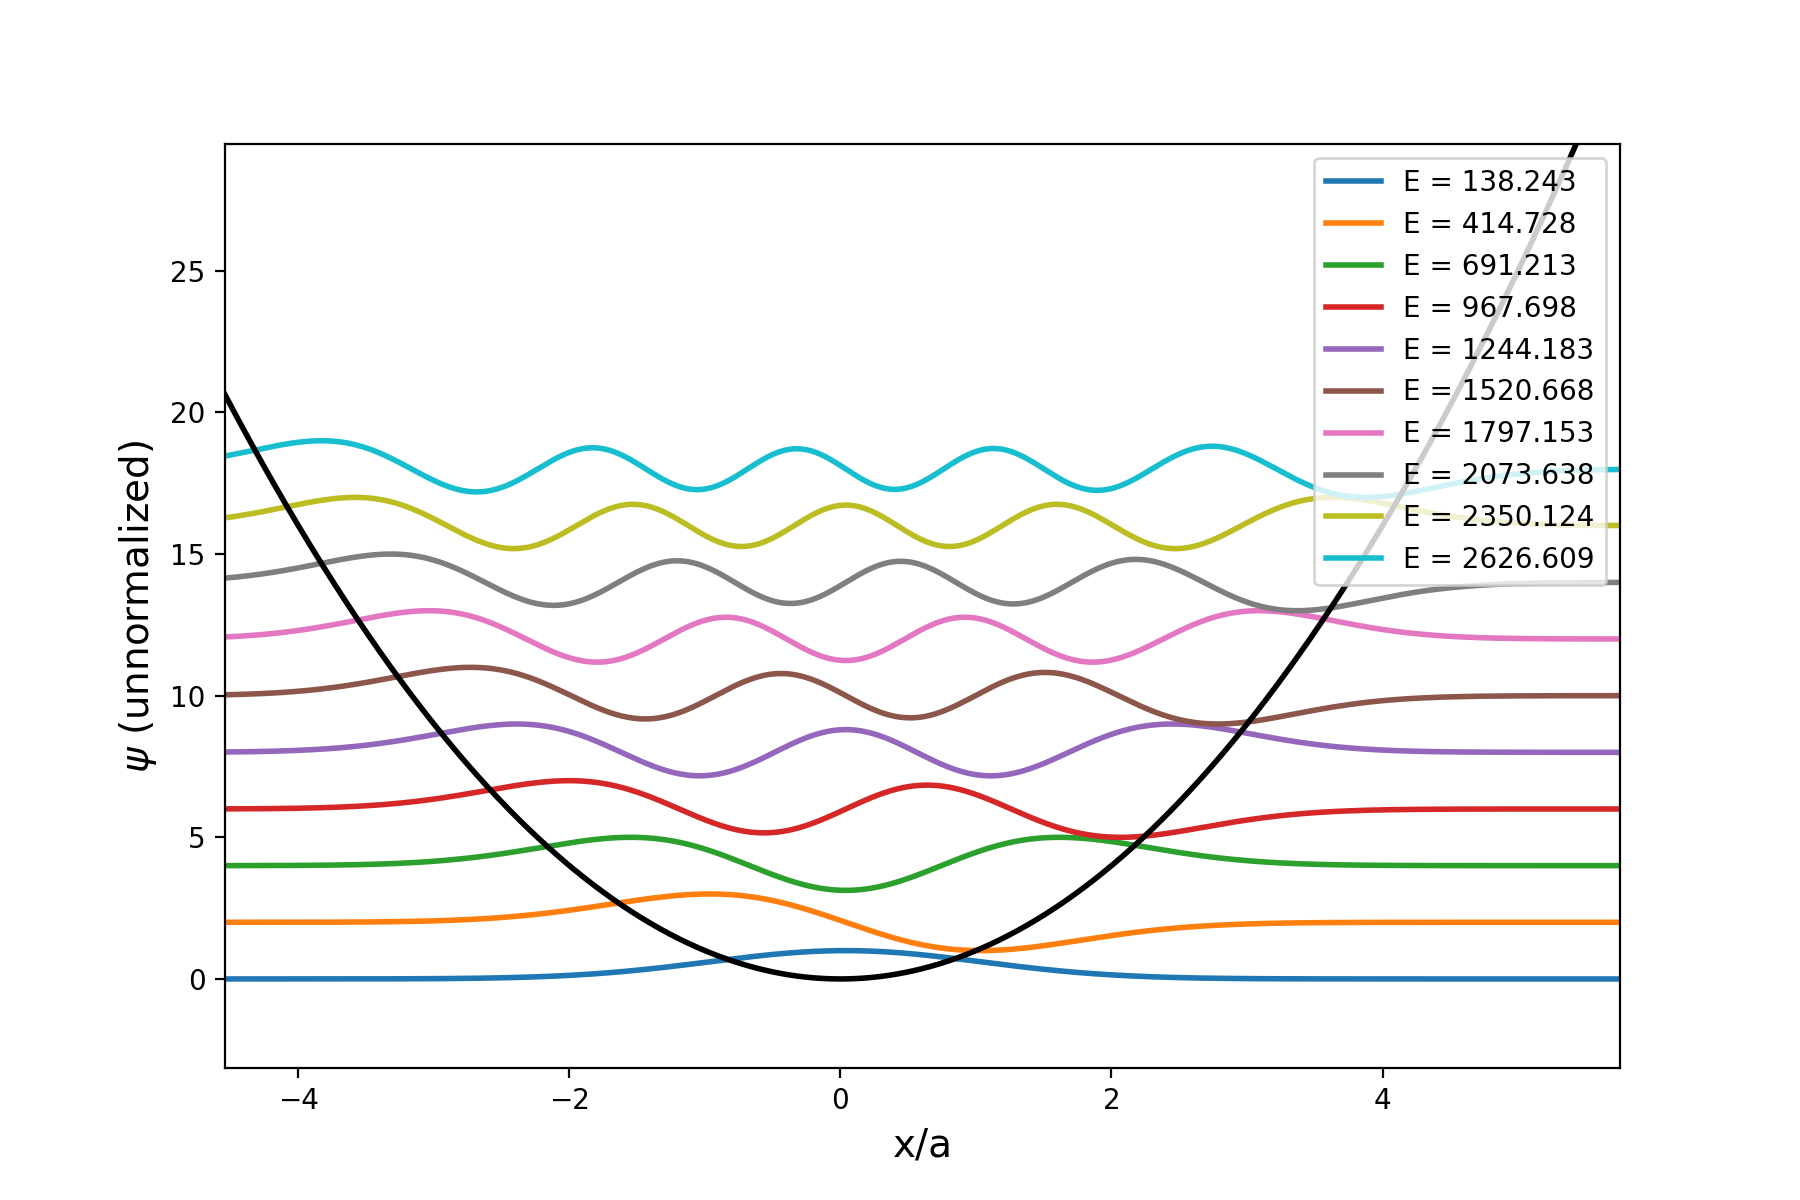

Energy found: 138.24257 eV
Energy found: 414.72769 eV
Energy found: 691.21281 eV
Energy found: 967.69794 eV
Energy found: 1244.18307 eV
Energy found: 1520.66820 eV
Energy found: 1797.15332 eV
Energy found: 2073.63845 eV
Energy found: 2350.12358 eV
Energy found: 2626.60869 eV


In [10]:
a = 1.0e-11
E1 = 135 # start Energy search at the well depth
dE = 0.5
npoints = 1000
m = 9.1*1.0e-31
hbar = 1.055*1.0e-34
count=-1
E_SM = []
fig = plt.figure(figsize = [9,6])
ax = fig.add_subplot(111)
# Bound states must have E < 0 for the square well.
# Cut off after we have found a few states
while (E1 < 2700):
    if match(E1)*match(E1 + dE) < 0 : # bracket E
        # find the energy
        E = rtf.bisect(match, E1, E1+dE, 1e-12)
        if E==None:continue
        print('Energy found: %.5f eV'%(E))
        count+=1
        E_SM.append(E)
        dx = 16*a/npoints
        # for plotting, must ensure overlap of left and right solutions
        p_up = QM(E, npoints = npoints+4, x_start = -10, x_end = 0+4*dx)
        p_down = QM(E, npoints = npoints-4, x_start = 10, x_end = 0+4*dx)
        p_up.scipy_trajectory()
        p_down.scipy_trajectory()
        # scale factor
        scale = p_up.uv_end[0]/p_down.uv_end[0]
        if (count % 2 != 0) and scale<0: scale =-scale
        #print('scale=',scale)
        # full solution, combine up and down solutions
        psi_x = np.concatenate((abs(scale)*p_up.uv[:-1,0], scale*p_down.uv[::-1,0]))
        xa = np.linspace(-10,10, 2*npoints-1, endpoint = True)
        # plot the scaled solution (not normalized), scale maximum to 1 for plotting purposes
        ax.plot(xa, psi_x/max(psi_x)+count*2, lw = 2, label = "E = {:.3f}".format(E))
        E1+=270
    #else :
    # print("No bracket, increasing energy to", E1+dE)
    E1 += dE
# plot the potential
ax.plot(xa, np.vectorize(p_up.Potential)(xa), color = 'k', lw =2)
ax.set_xlim([-10, 10])
ax.set_xlabel('x/a', fontsize = 14)
ax.set_ylabel('$\psi$ (unnormalized)', fontsize = 14)
ax.legend(loc = 1, fontsize =10,numpoints=1)
plt.show()

I use $\xi=\sqrt{\frac{m\omega}{\hbar}}x$, where $\omega=\sqrt{\hbar}{ma^2}$, so as to avoid numerical errors in this problem. If the Hamiltonian is chosen to have unit $\hbar\omega$, the expression becomes: $$H=-\frac{1}{2}\frac{d^2}{d\xi^2}+\frac{1}{2}\xi^2$$
From the Energy levels we find above, we can see they are equally spaced with a gap about 276 eV, which is the value of $\hbar\omega$.

**Problem 1(b)**

In [12]:
E_HO=np.array([138.24257,414.72769,691.21281,967.69794,1244.18307,1520.66820,1797.15332,2073.63845,
               2350.12358,2626.60869])
print(E_HO)

[ 138.24257  414.72769  691.21281  967.69794 1244.18307 1520.6682
 1797.15332 2073.63845 2350.12358 2626.60869]


In [13]:
class QM1b(object):

    def __init__(self, E, npoints, x_start, x_end = 0, u0 = 0.0, v0 = 0.01):
        self.E = E*1.6e-19/hw
        self.npoints = npoints
        self.a = 1.0e-11 
        self.uv0 = np.array([u0, v0]) 
        # NumPy array with initial position and velocity
        # always want to start at furthest point and go to zero
        self.xarray = np.linspace(x_start, x_end, npoints, endpoint = True) 
        # include final timepoint
        
    def scipy_trajectory(self):
        """calculate trajectory using SciPy ode integrator"""
        self.uv = odeint(self.sch, self.uv0, self.xarray)
        self.uv_end = self.uv[-1]

    def sch(self, uv, x):
        """right hand side of the differential equation"""
        u = uv[1]
        v = (self.Potential(x) - 2*self.E)*uv[0]
        #print('u=',u,'v=',v)
        return np.ravel(np.array([u, v]))

    def Potential(self, x): 
        num1=x**2+0.1*x**4
        #print('V=',num1)
        return num1

<IPython.core.display.Javascript object>


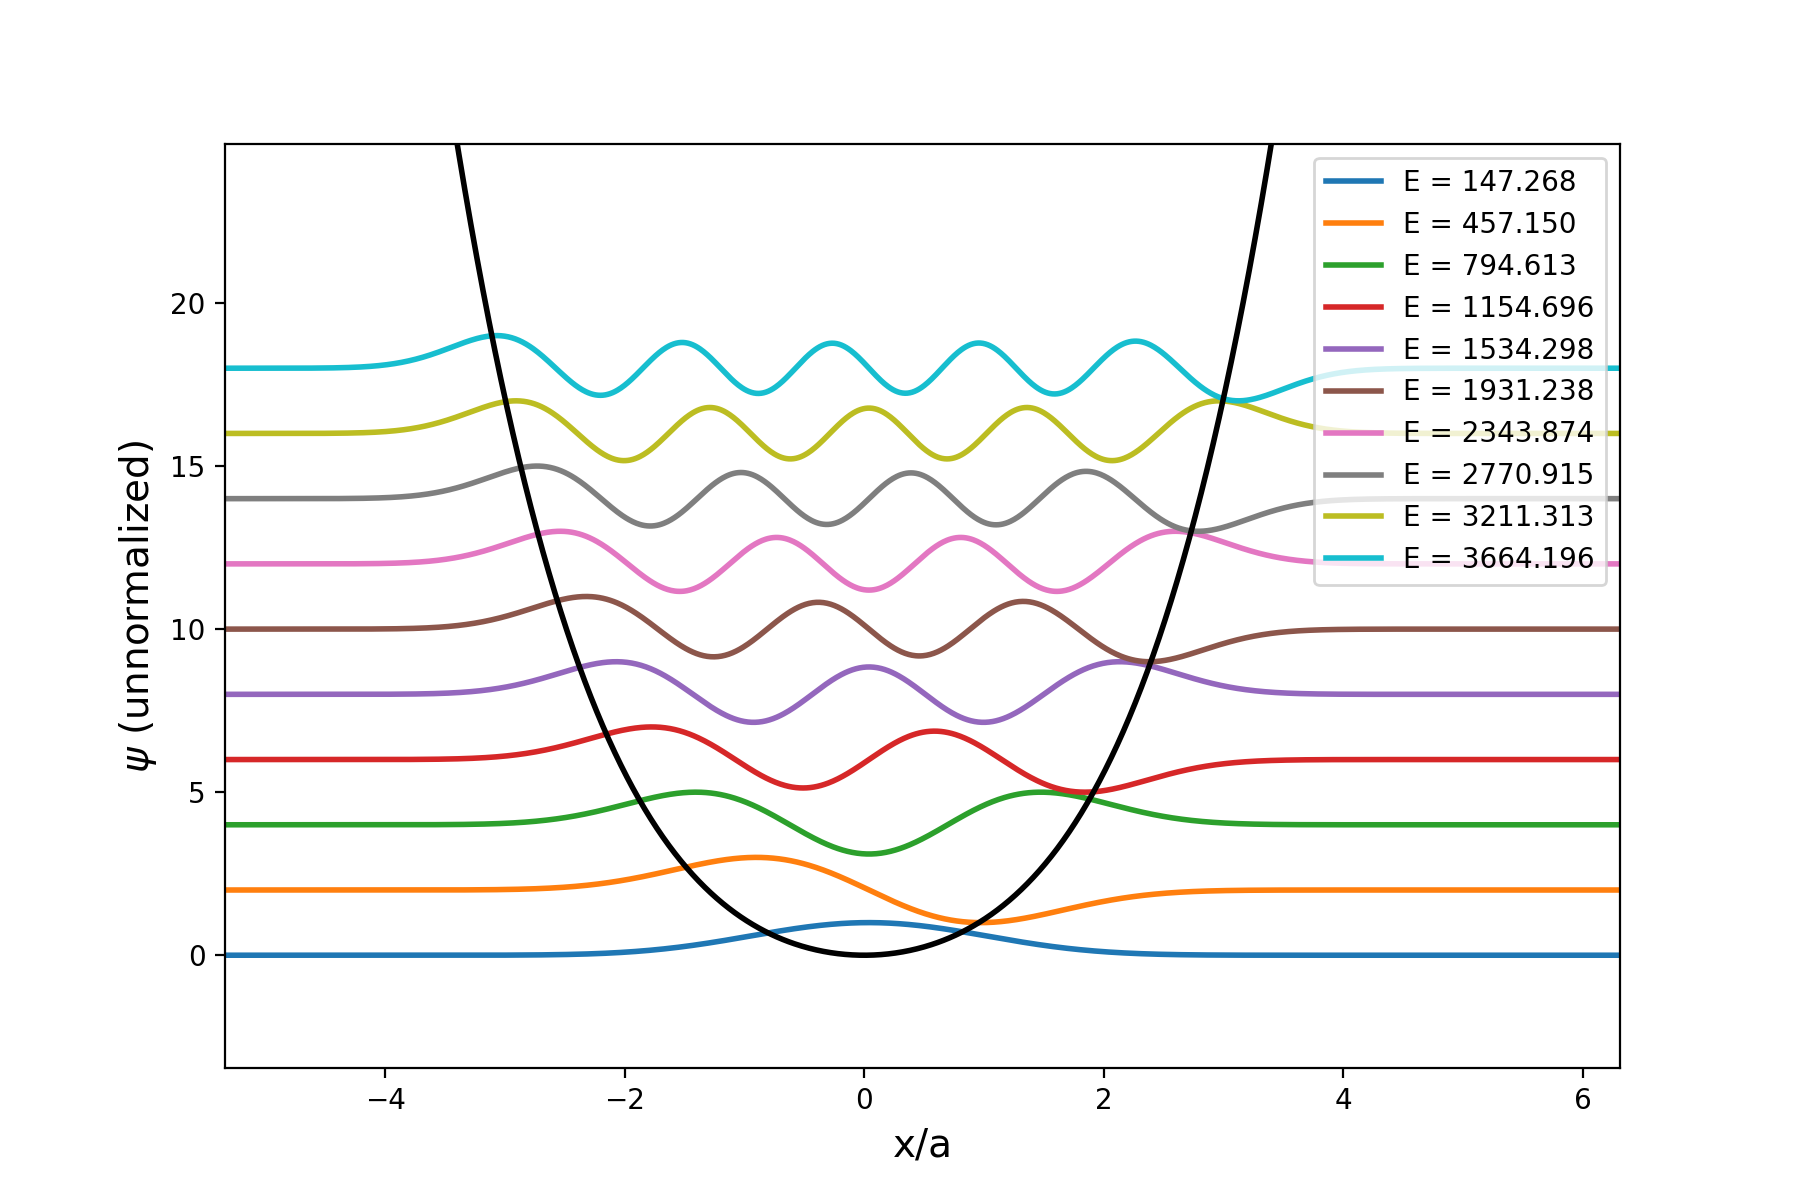

Energy found: 147.26781 eV
Energy found: 457.15047 eV
Energy found: 794.61263 eV
Energy found: 1154.69559 eV
Energy found: 1534.29830 eV
Energy found: 1931.23840 eV
Energy found: 2343.87426 eV
Energy found: 2770.91509 eV
Energy found: 3211.31284 eV
Energy found: 3664.19582 eV


In [17]:
a = 1.0e-11
E1 = 100 # start Energy search at the well depth
dE = 0.5
npoints = 1000
m = 9.1*1.0e-31
hbar = 1.055*1.0e-34
count=-1
E_SM = []
fig = plt.figure(figsize = [9,6])
ax = fig.add_subplot(111)
# Bound states must have E < 0 for the square well.
# Cut off after we have found a few states
while (E1 < 4000):
    if match(E1)*match(E1 + dE) < 0 : # bracket E
        # find the energy
        E = rtf.bisect(match, E1, E1+dE, 1e-12)
        if E==None:continue
        print('Energy found: %.5f eV'%(E))
        count+=1
        E_SM.append(E)
        dx = 16*a/npoints
        # for plotting, must ensure overlap of left and right solutions
        p_up = QM(E, npoints = npoints+4, x_start = -10, x_end = 0+4*dx)
        p_down = QM(E, npoints = npoints-4, x_start = 10, x_end = 0+4*dx)
        p_up.scipy_trajectory()
        p_down.scipy_trajectory()
        # scale factor
        scale = p_up.uv_end[0]/p_down.uv_end[0]
        if (count % 2 != 0) and scale<0: scale =-scale
        #print('scale=',scale)
        # full solution, combine up and down solutions
        psi_x = np.concatenate((abs(scale)*p_up.uv[:-1,0], scale*p_down.uv[::-1,0]))
        xa = np.linspace(-10,10, 2*npoints-1, endpoint = True)
        # plot the scaled solution (not normalized), scale maximum to 1 for plotting purposes
        ax.plot(xa, psi_x/max(psi_x)+count*2, lw = 2, label = "E = {:.3f}".format(E))
        E1+=300
    #else :
    # print("No bracket, increasing energy to", E1+dE)
    E1 += dE
# plot the potential
ax.plot(xa, np.vectorize(p_up.Potential)(xa), color = 'k', lw =2)
ax.set_xlim([-10, 10])
ax.set_xlabel('x/a', fontsize = 14)
ax.set_ylabel('$\psi$ (unnormalized)', fontsize = 14)
ax.legend(loc = 1, fontsize =10,numpoints=1)
plt.show()

In [30]:
E_aHO=np.array([147.26781,457.15047,794.61263,1154.69559,1534.29830,
                1931.23840,2343.87426,2770.91509,3211.31284,3664.19582])
E_level=np.linspace(0,9,10)
print(E_level)

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


<IPython.core.display.Javascript object>


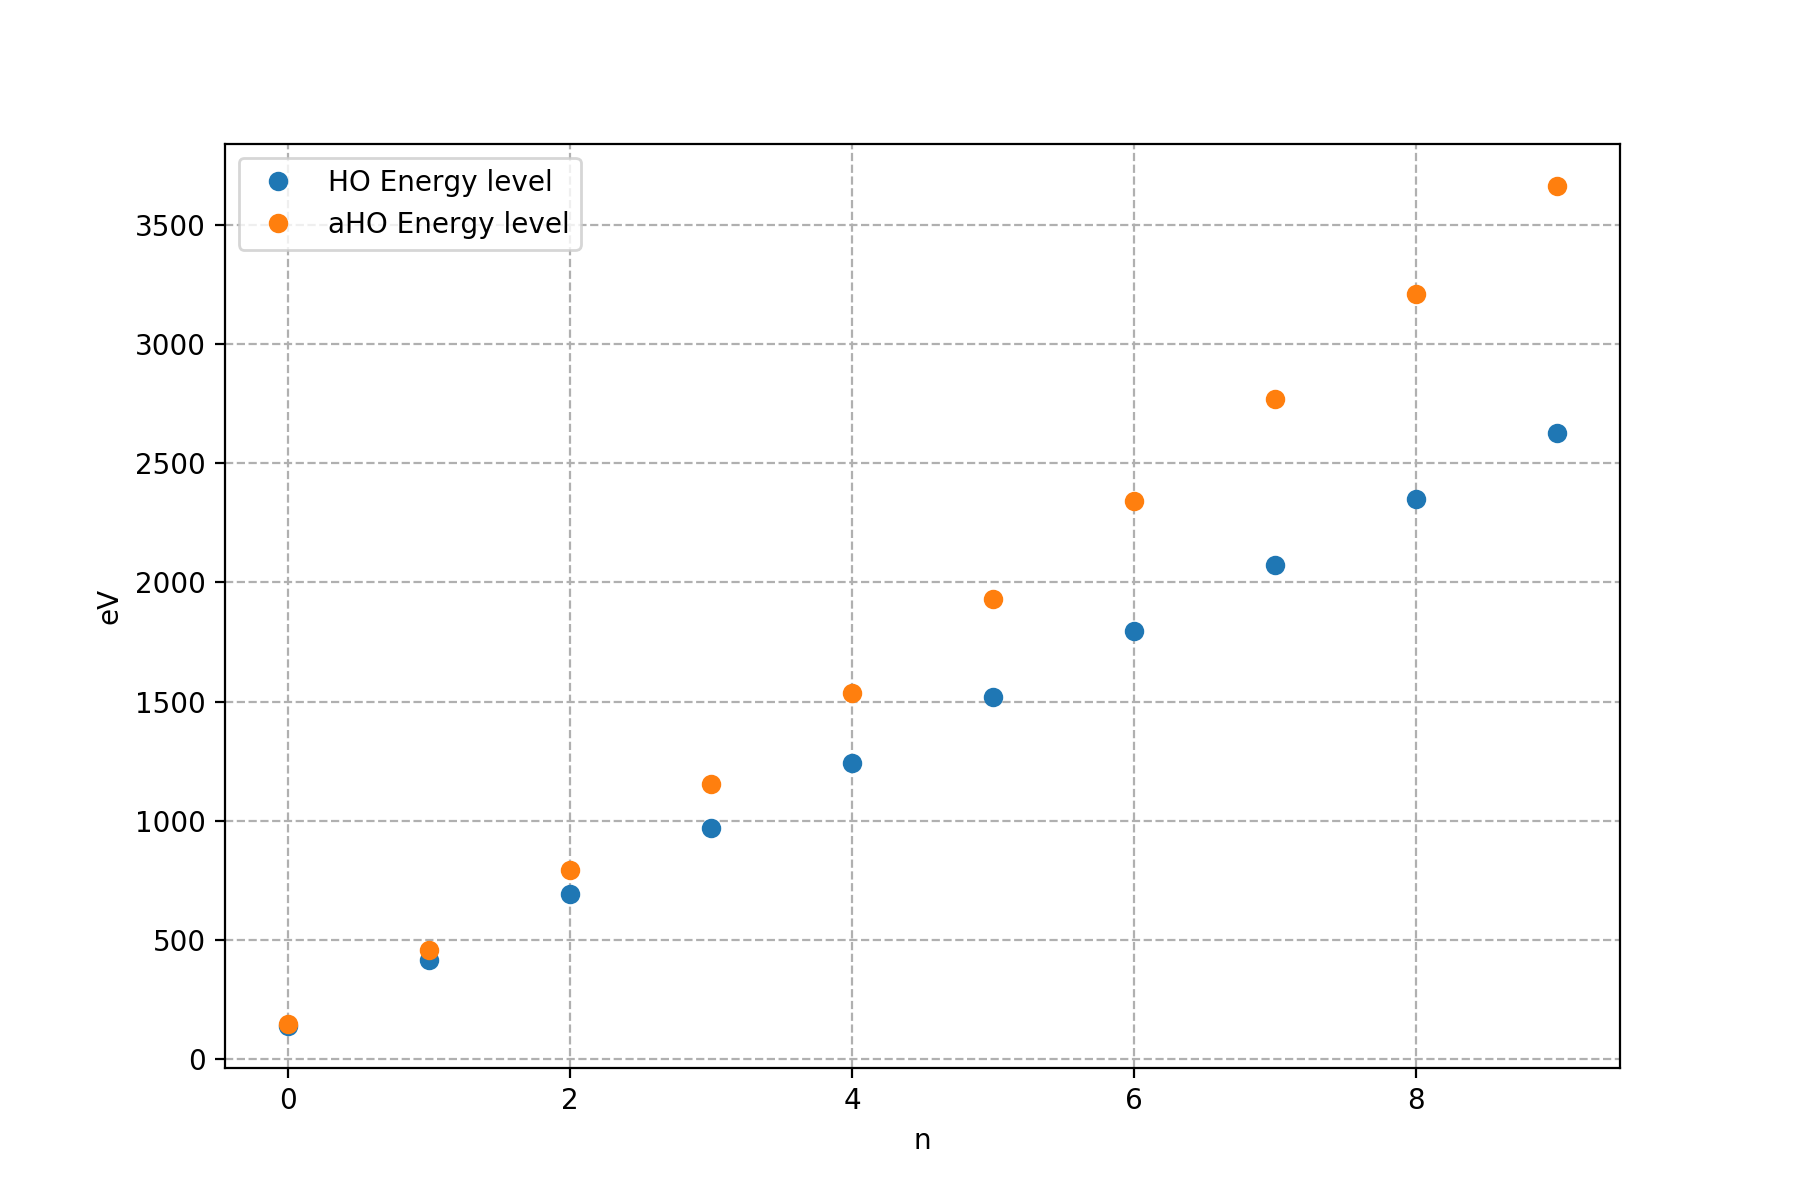

In [31]:
fig1 = plt.figure(figsize = [9,6])
ax1 = fig1.add_subplot(111)
ax1.plot(E_level, E_HO, 'o',label='HO Energy level')
ax1.plot(E_level, E_aHO,'o',label='aHO Energy level')
ax1.grid(ls='--')
ax1.set_xlabel('n')
ax1.set_ylabel('eV')
ax1.legend()

Energy levels versus n for Harmonic Oscillator and Anharmonic Oscillator have been plotted above. Apart from equally spaced levels for HO, anharmonic case the spacing between each level keeps growing.

**Problem 1(c)**

In [34]:
class QM1c(object):

    def __init__(self, E, npoints, x_start, x_end = 0, u0 = 0.0, v0 = 0.01):
        self.E = E*1.6e-19/hw
        self.npoints = npoints
        self.a = 1.0e-11 
        self.uv0 = np.array([u0, v0]) 
        # NumPy array with initial position and velocity
        # always want to start at furthest point and go to zero
        self.xarray = np.linspace(x_start, x_end, npoints, endpoint = True) 
        # include final timepoint
        
    def scipy_trajectory(self):
        """calculate trajectory using SciPy ode integrator"""
        self.uv = odeint(self.sch, self.uv0, self.xarray)
        self.uv_end = self.uv[-1]

    def sch(self, uv, x):
        """right hand side of the differential equation"""
        u = uv[1]
        v = (self.Potential(x) - 2*self.E)*uv[0]
        #print('u=',u,'v=',v)
        return np.ravel(np.array([u, v]))

    def Potential(self, x): 
        num1=x**2+0.1*x**4
        #print('V=',num1)
        return num1

<IPython.core.display.Javascript object>


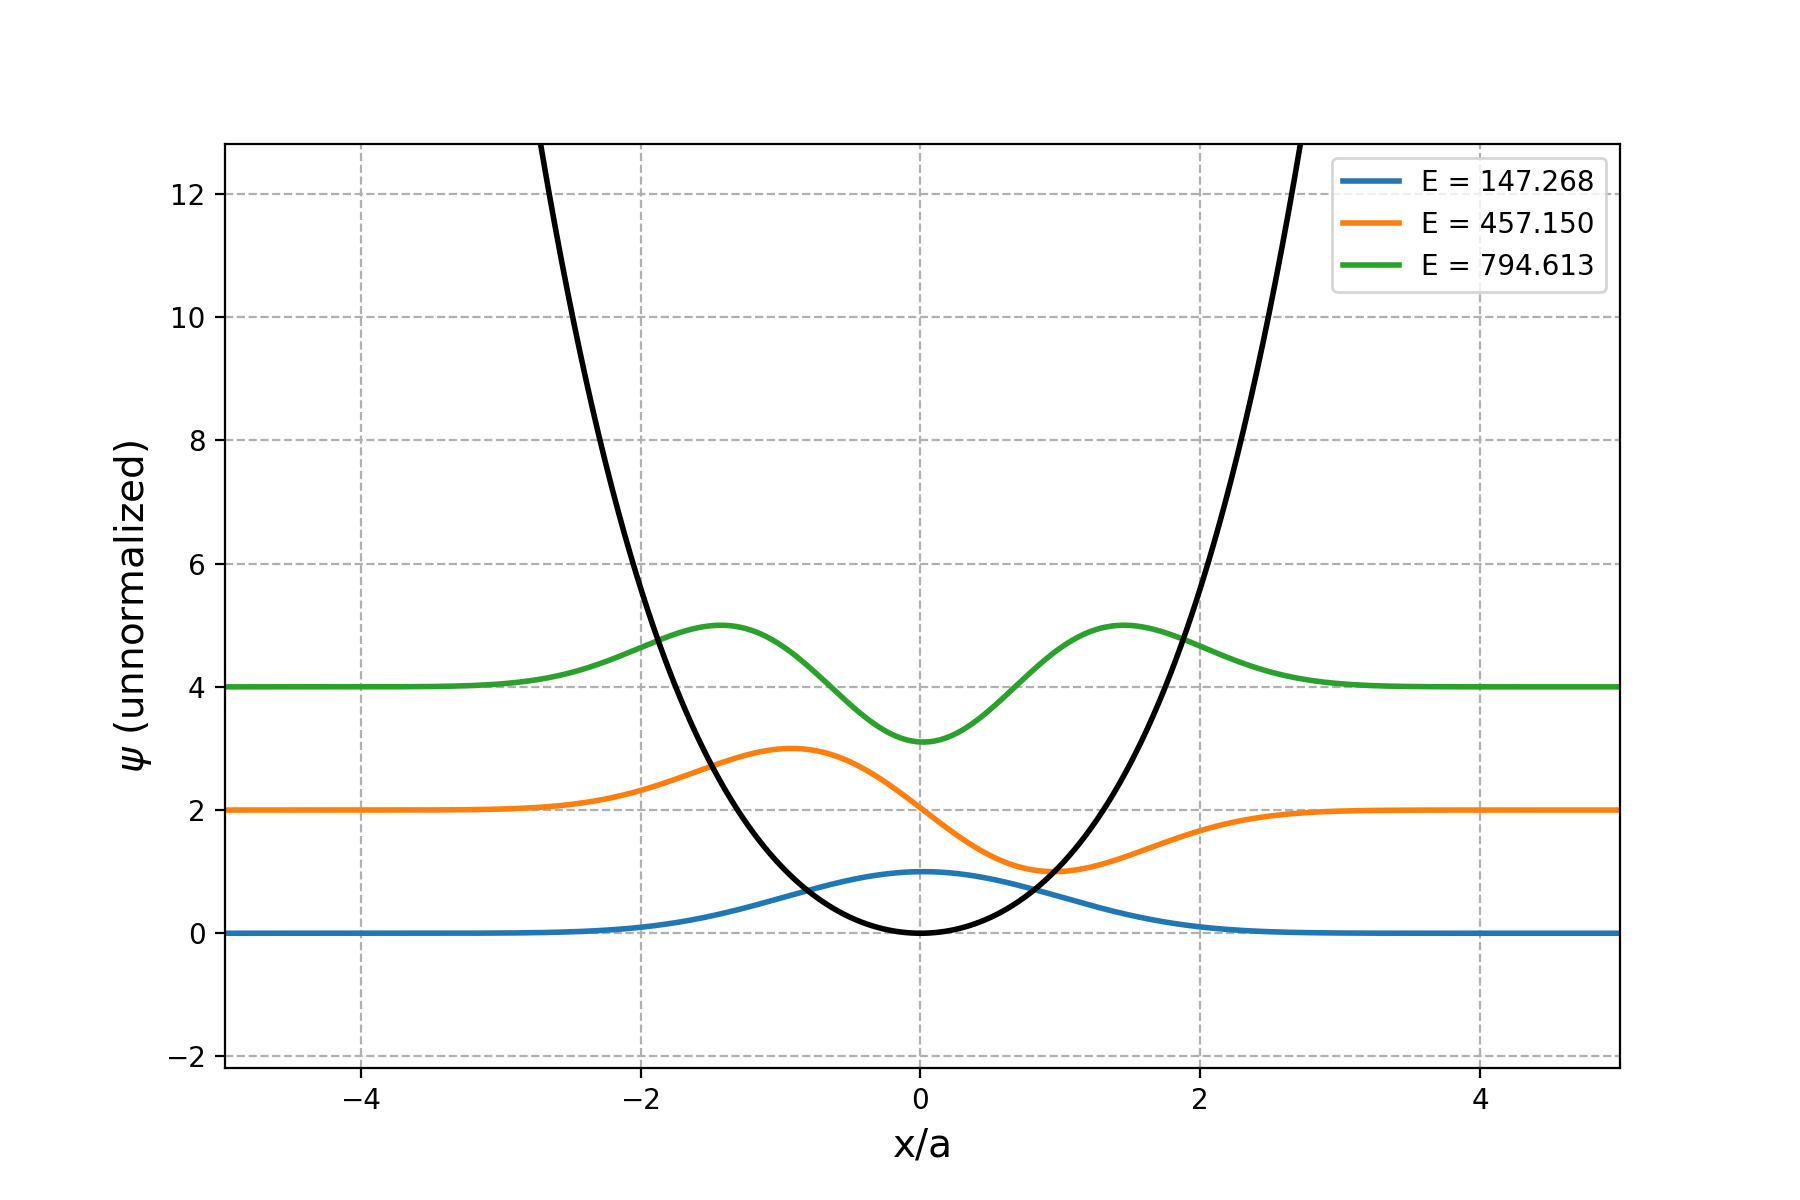

Energy found: 147.26780 eV
Energy found: 457.15046 eV
Energy found: 794.61262 eV


In [36]:
a = 1.0e-11
E1 = 100 # start Energy search at the well depth
dE = 0.5
npoints = 1000
m = 9.1*1.0e-31
hbar = 1.055*1.0e-34
count=-1
E_SM = []
fig = plt.figure(figsize = [9,6])
ax = fig.add_subplot(111)
# Bound states must have E < 0 for the square well.
# Cut off after we have found a few states
while (E1 < 1000):
    if match(E1)*match(E1 + dE) < 0 : # bracket E
        # find the energy
        E = rtf.bisect(match, E1, E1+dE, 1e-12)
        if E==None:continue
        print('Energy found: %.5f eV'%(E))
        count+=1
        E_SM.append(E)
        dx = 16*a/npoints
        # for plotting, must ensure overlap of left and right solutions
        p_up = QM(E, npoints = npoints+4, x_start = -5, x_end = 0+4*dx)
        p_down = QM(E, npoints = npoints-4, x_start = 5, x_end = 0+4*dx)
        p_up.scipy_trajectory()
        p_down.scipy_trajectory()
        # scale factor
        scale = p_up.uv_end[0]/p_down.uv_end[0]
        if (count % 2 != 0) and scale<0: scale =-scale
        #print('scale=',scale)
        # full solution, combine up and down solutions
        psi_x = np.concatenate((abs(scale)*p_up.uv[:-1,0], scale*p_down.uv[::-1,0]))
        xa = np.linspace(-5,5, 2*npoints-1, endpoint = True)
        # plot the scaled solution (not normalized), scale maximum to 1 for plotting purposes
        ax.plot(xa, psi_x/max(psi_x)+count*2, lw = 2, label = "E = {:.3f}".format(E))
        #E1+=300
    #else :
    # print("No bracket, increasing energy to", E1+dE)
    E1 += dE
# plot the potential
ax.plot(xa, np.vectorize(p_up.Potential)(xa), color = 'k', lw =2)
ax.set_xlim([-5, 5])
ax.set_xlabel('x/a', fontsize = 14)
ax.set_ylabel('$\psi$ (unnormalized)', fontsize = 14)
ax.legend(loc = 1, fontsize =10,numpoints=1)
ax.grid(ls='--')
plt.show()

The three lowest wave functions of the anharmonic oscillator have been plotted in the figure above. 

**Problem 2(a)**

In [43]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [51]:
def free_space(phi): return phi

def square_cylinder(phi):
    """ 
    define a cylinder potential
    """
   # the operator // is floor division i.e divide and then round down to nearest integer.
   # Using this ensures that the result is an integer so we can use it to index arrays.
    
    n, m = np.shape(phi)
    w = n//2
    h = n//5  # span 1/3 of grid in height`
    
    right = w + h//2 #position of plate 1
    left = w - h//2  # positioin of plate 2
    phi[2*h:3*h, left] =  1
    phi[2*h:3*h, right] =  1
    phi[left,2*h:3*h] =  1
    phi[right,2*h:3*h] =  1
    
    return phi

def box():
    # define boundary conditions for a box
    
    return phi

def pipe(phi):
    n,m = np.shape(phi)
    r = n/200
    tol = np.sqrt(n**2 + m**2)

    X,Y = np.meshgrid(range(-n//2, n//2+1), range(-m//2, m//2+1))
    Z = np.sqrt((X-n//8)**2 + (Y)**2)
    
    idx = np.nonzero(abs(Z-r) < 1)
    phi[idx] =  1
    return phi

In [52]:
def invDel2_5(b, boundary,  dx=1.0, converge = 1e-6):
    """ This is the Jacobi algorithim 
    Specialized to two dimensions so that plotting is easier.
    """
    V = boundary(np.zeros(b.shape, float))  # potential values at step n of the iteration   
    Vnew = np.zeros(b.shape, float) # updated potential 
    Npoints = len(b.flatten())

    t = 0  # transient before checking for convergence
    dV = converge*10  #make sure we run through transient
    
    while(dV > converge): 
        # this update fixes V along edges = 0
        Vnew[1:-1, 1:-1] = (V[1:-1,2:] + V[1:-1,:-2] + V[2:,1:-1] \
                + V[:-2,1:-1] - (dx*dx)*b[1:-1,1:-1])/4
        
        # enforce the boundary conditions at every update
        Vnew = boundary(Vnew)
        
        # wait for transient before checking convergence
        if t > 100 : 
            dV = np.sum(abs(Vnew - V))/Npoints
        
        # Note the explicit indexing (V[:,:]) without it Vnew will be updated with V
        V[:,:] = Vnew 
        # for mor complex objects i.e. list with sublists use deepcopy
        t+=1
   
    return Vnew

In [55]:
N = 100 #grid points
dx = 1/N

# generate coordinates for each grid point
# only required for plotting E-field
X,Y = np.meshgrid(range(-N//2, N//2+1), range(-N//2, N//2+1))


# the charge distrubution defines space for us
# empty space, no charge
rho = np.zeros([N+1, N+1])
#rho = pipe(rho)*-5000

# solution from relaxation
phi = invDel2_5(rho, square_cylinder, dx)

# Calculate the electric field
EY, EX = -1*np.array(np.gradient(phi))
magE = np.sqrt(EX**2 + EY**2)

# Note, this step was not completed in shared notebook, so plots will look a bit messy
# supress division by zero error output
np.seterr(divide = 'ignore', invalid = 'ignore')
EX= np.divide(EX,magE)
EY= np.divide(EY,magE)


<IPython.core.display.Javascript object>


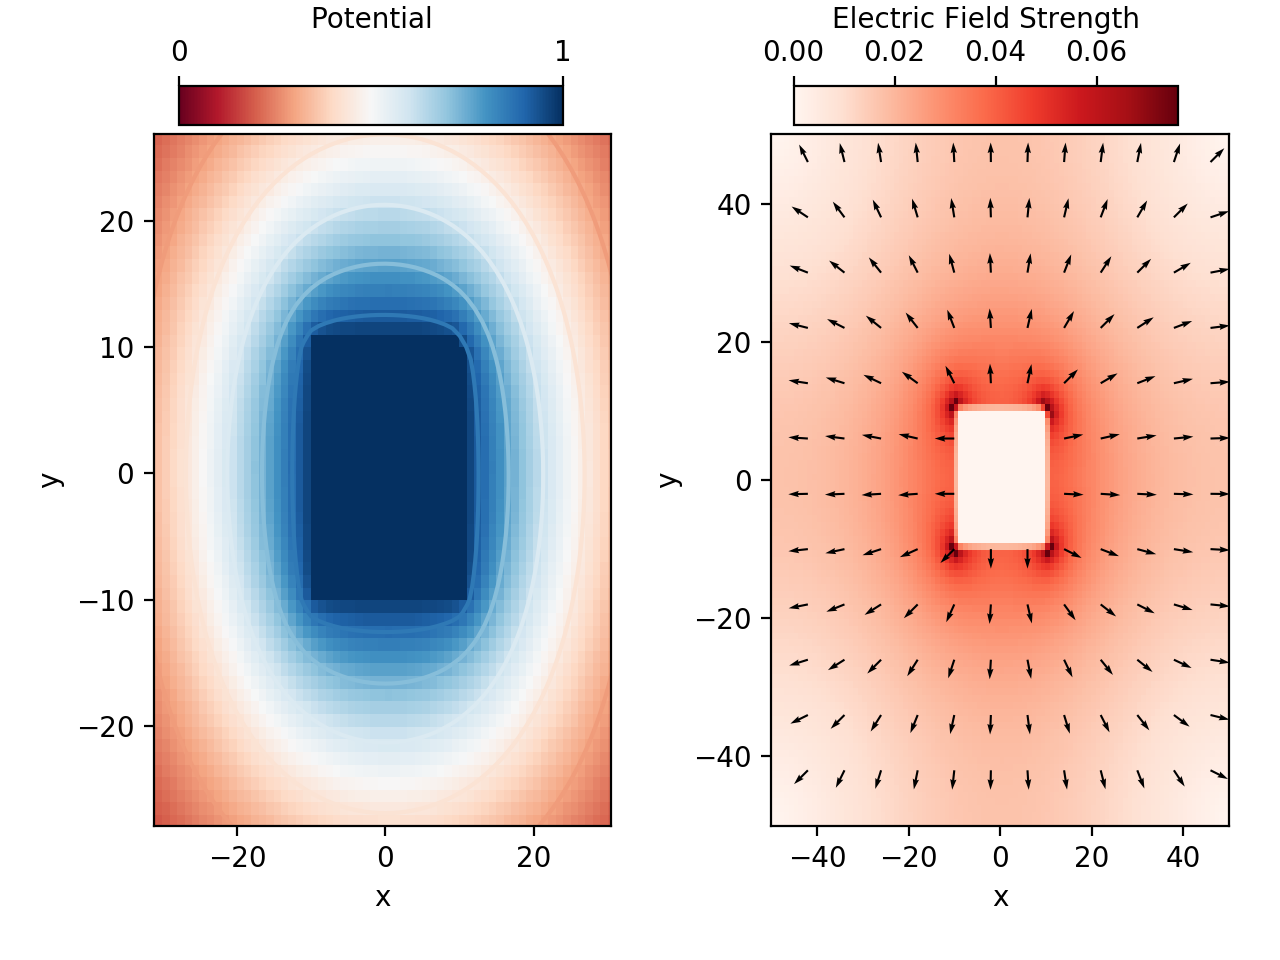

<IPython.core.display.Javascript object>


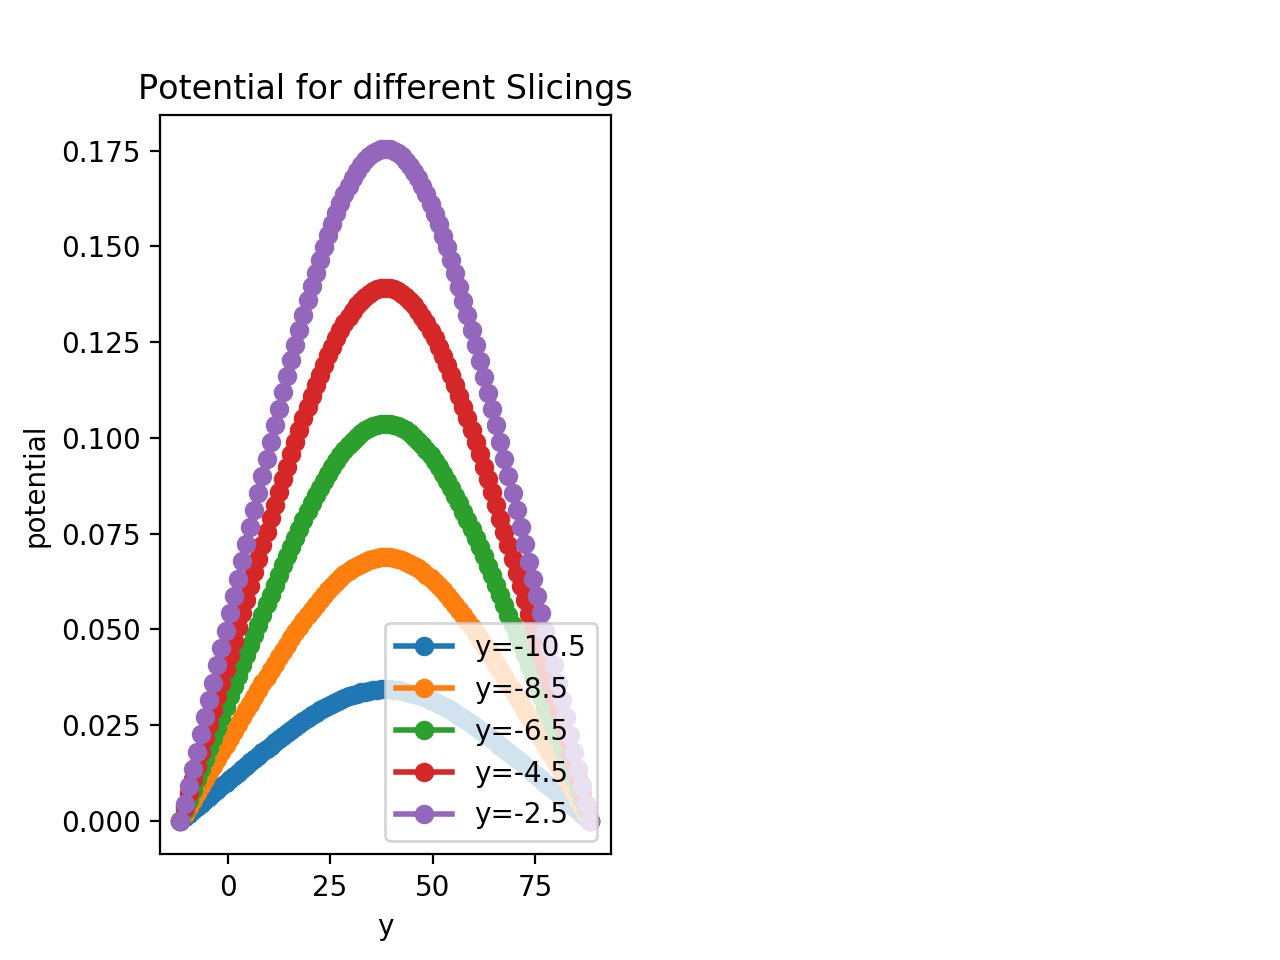

In [58]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig1 = plt.figure()
ax3 = fig1.add_subplot(121)

# plot potential
m1 = ax1.pcolormesh(X, Y, phi, cmap = 'RdBu')

# add an axes to put colorbar is custom location
cax1 = fig.add_axes([0.14,0.87,0.3,0.04])
# create colorbar
cbar = fig.colorbar(m1,cax1, orientation = 'horizontal', ticklocation = 'top', ticks = [-1,0,1])
cbar.set_label('Potential')

# add contour lines
ax1.contour(X,Y,phi, cmap = 'RdBu')
ax1.set_xlabel("x")
ax1.set_ylabel("y")

# plot E-field 
m2 = ax2.pcolormesh(X,Y,magE, cmap = 'Reds')

cax2 = fig.add_axes([0.62,0.87,0.3,0.04])
cbar2 = fig.colorbar(m2,cax2,orientation = 'horizontal', ticklocation = 'top' )
cbar2.set_label('Electric Field Strength')
ax2.quiver(X[::8,::8],Y[::8,::8],EX[::8,::8], EY[::8, ::8], units = 'width') 
ax2.set_xlabel("x")
ax2.set_ylabel("y")

ypos = []
yori = -12.5
for i in range (len(phi)):
    yori += 1
    ypos.append(yori)
ax3.plot(ypos,phi[2,:], lw =2, marker='o', label='y=-10.5')
ax3.plot(ypos,phi[4,:],lw =2, marker='o', label='y=-8.5')
ax3.plot(ypos,phi[6,:],lw =2, marker='o', label='y=-6.5')
ax3.plot(ypos,phi[8,:],lw =2, marker='o', label='y=-4.5')
ax3.plot(ypos,phi[10,:],lw =2, marker='o', label='y=-2.5')
ax3.legend(loc = 4, fontsize =10,numpoints = 1 )
ax3.set_title('Potential for different Slicings')
ax3.set_ylabel("potential")
ax3.set_xlabel("y")

fig.subplots_adjust(left = 0.12,right = 0.96, bottom = 0.14, top = 0.86,wspace =0.35, hspace = 0.35)



**Problem 2(b)**

In [59]:
def parallel_plate(phi):

    """
    define parallel plate potential
    """
    # the operator // is floor division i.e divide and then round down to nearest integer.
    # Using this ensures that the result is an integer so we can use it to index arrays.
    n, m = np.shape(phi)
    w = n//2
    h = n//3 # span 1/3 of grid in height`
    right = w + h//2 #position of plate 1
    left = w - h//2 # positioin of plate 2
    phi[h:2*h, left] = - 1
    phi[h:2*h, right] = 1
    return phi

<IPython.core.display.Javascript object>


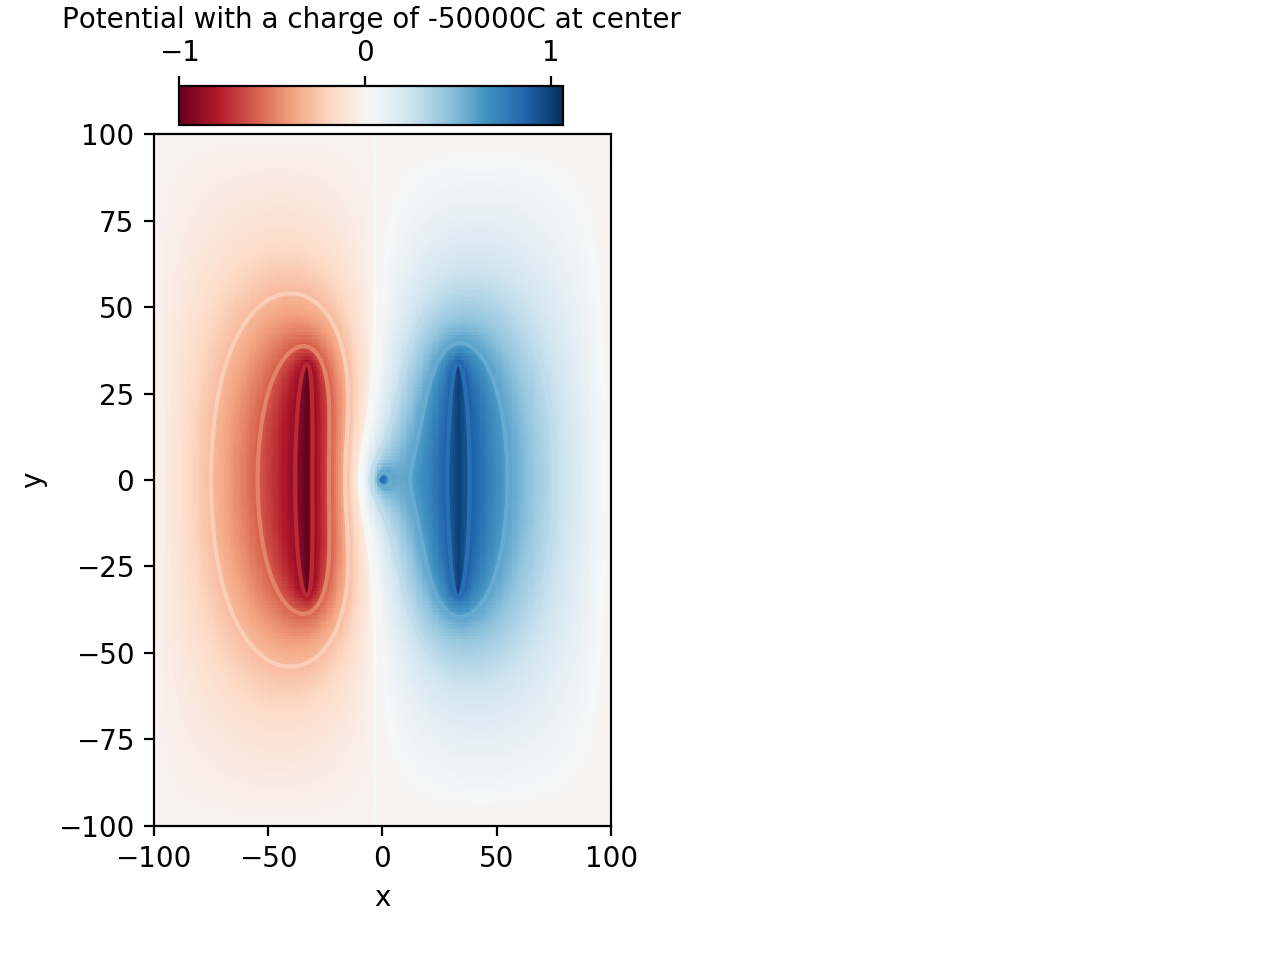

In [60]:
N = 200 #grid points

dx = 1/N
X,Y = np.meshgrid(range(-N//2, N//2+1), range(-N//2, N//2+1))
# the charge distrubution defines space for us
rho = np.zeros([N+1, N+1])
#rho = pipe(rho)*-5000
rho[100,100] = -50000
# solution from relaxation
phi = invDel2_5(rho, parallel_plate, dx)
fig = plt.figure()
ax1 = fig.add_subplot(121)
# plot potential
m1 = ax1.pcolormesh(X, Y, phi, cmap = 'RdBu')

# add contour lines
ax1.contour(X,Y,phi, cmap = 'RdBu')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
# add an axes to put colorbar is custom location
cax1 = fig.add_axes([0.14,0.87,0.3,0.04])
# create colorbar
cbar = fig.colorbar(m1,cax1, orientation = 'horizontal', ticklocation = 'top', ticks = [-1,0,1])
cbar.set_label('Potential with a charge of -50000C at center')
fig.subplots_adjust(left = 0.12,right = 0.96, bottom = 0.14, top = 0.86,wspace =0.35, hspace = 0.35)

<IPython.core.display.Javascript object>


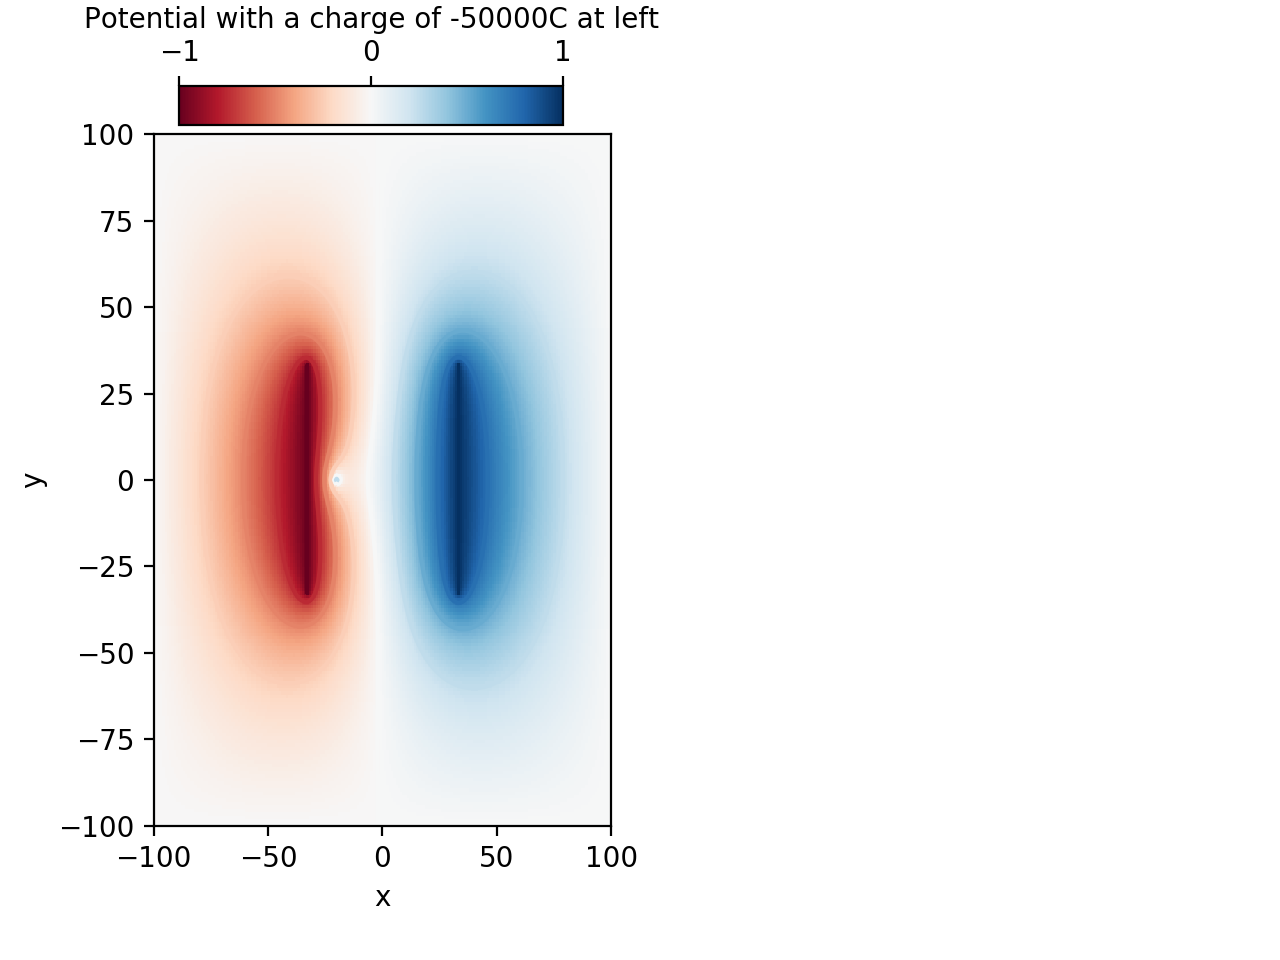

In [62]:
N = 200 #grid points

dx = 1/N
X,Y = np.meshgrid(range(-N//2, N//2+1), range(-N//2, N//2+1))
# the charge distrubution defines space for us
rho = np.zeros([N+1, N+1])
#rho = pipe(rho)*-5000
rho[100,80] = -50000
# solution from relaxation
phi = invDel2_5(rho, parallel_plate, dx)
fig = plt.figure()
ax1 = fig.add_subplot(121)
# plot potential
m1 = ax1.pcolormesh(X, Y, phi, cmap = 'RdBu')

# add contour lines
ax1.contour(X,Y,phi, cmap = 'RdBu')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
# add an axes to put colorbar is custom location
cax1 = fig.add_axes([0.14,0.87,0.3,0.04])
# create colorbar
cbar = fig.colorbar(m1,cax1, orientation = 'horizontal', ticklocation = 'top', ticks = [-1,0,1])
cbar.set_label('Potential with a charge of -50000C at left')
fig.subplots_adjust(left = 0.12,right = 0.96, bottom = 0.14, top = 0.86,wspace =0.35, hspace = 0.35)

<IPython.core.display.Javascript object>


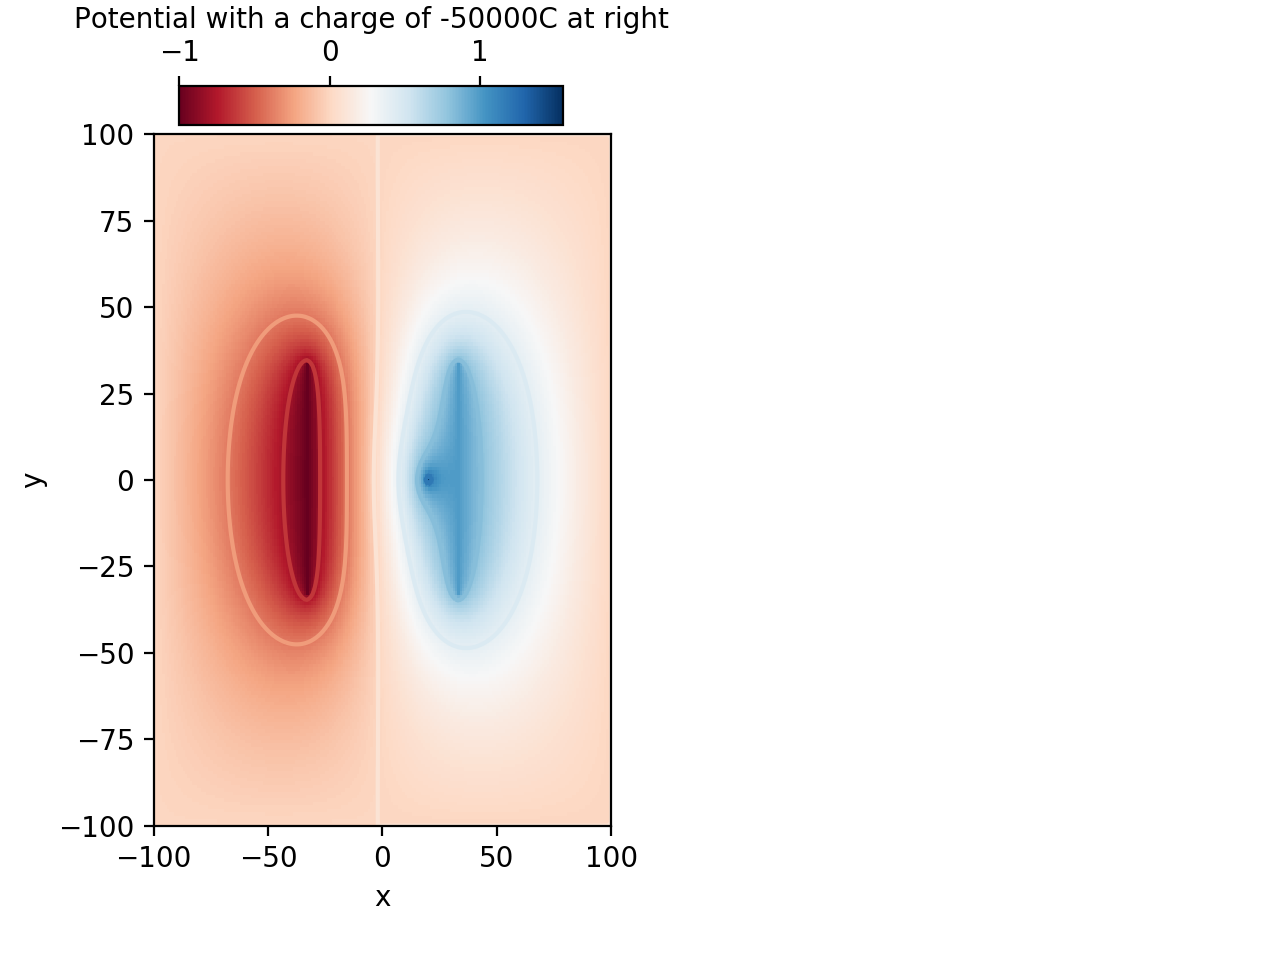

In [63]:
N = 200 #grid points

dx = 1/N
X,Y = np.meshgrid(range(-N//2, N//2+1), range(-N//2, N//2+1))
# the charge distrubution defines space for us
rho = np.zeros([N+1, N+1])
#rho = pipe(rho)*-5000
rho[100,120] = -50000
# solution from relaxation
phi = invDel2_5(rho, parallel_plate, dx)
fig = plt.figure()
ax1 = fig.add_subplot(121)
# plot potential
m1 = ax1.pcolormesh(X, Y, phi, cmap = 'RdBu')

# add contour lines
ax1.contour(X,Y,phi, cmap = 'RdBu')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
# add an axes to put colorbar is custom location
cax1 = fig.add_axes([0.14,0.87,0.3,0.04])
# create colorbar
cbar = fig.colorbar(m1,cax1, orientation = 'horizontal', ticklocation = 'top', ticks = [-1,0,1])
cbar.set_label('Potential with a charge of -50000C at right')
fig.subplots_adjust(left = 0.12,right = 0.96, bottom = 0.14, top = 0.86,wspace =0.35, hspace = 0.35)

From the figures we plotted, we can infer that the equipotential contours will be distorted as the charge moves around.